# Basic usage of the package

Welcome to the first tutorial of Gensor. Here we will explore the core features of the package which come with the base classes: [`Timeseries`](../../modules/#gensor.Timeseries) and [`Dataset`](../../modules/#gensor.Dataset).

In [1]:
import gensor as gs
from gensor.testdata import all_paths, pb02a_plain

## Creating a Timeseries

Essentially `Timeseries` wraps a `pandas.Series` in a layer of additional metadata (sensor name, location, elevation of the sensor, etc.) and functionality (serialization, compensation for atmospheric pressure, etc.) that are specific in groundwater sensor timeseries analysis.

For a basic example, let's take a simple, generic pandas.Series of barometric pressure and dump the resulting model to a dictionary to see what attributes does it have:

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin-top: 10px;" class="admonition-content">    The pandas.Series that goes into the Timeseries object as an attribute has have a timezone-aware DateTimeIndex type. </p>
</div>

In [2]:
import pandas as pd
import numpy as np

timestamps = pd.date_range(start='2024-01-01 00:00', periods=10, freq='h', tz='UTC')

barometric_pressure = np.random.uniform(low=980, high=1050, size=10)

pressure_series = pd.Series(data=barometric_pressure, index=timestamps, name="Barometric Pressure")

ts = gs.Timeseries(ts=pressure_series,
                   variable='pressure',
                   unit='cmh2o',
                   location='BH1',
                   sensor='ABC123')

ts.model_dump()


{'ts': 2024-01-01 00:00:00+00:00    1029.317083
 2024-01-01 01:00:00+00:00     981.815088
 2024-01-01 02:00:00+00:00    1031.546451
 2024-01-01 03:00:00+00:00    1005.477899
 2024-01-01 04:00:00+00:00    1007.629369
 2024-01-01 05:00:00+00:00     980.362589
 2024-01-01 06:00:00+00:00    1037.469614
 2024-01-01 07:00:00+00:00     988.098823
 2024-01-01 08:00:00+00:00    1030.572908
 2024-01-01 09:00:00+00:00    1002.985316
 Freq: h, Name: Barometric Pressure, dtype: float64,
 'variable': 'pressure',
 'unit': 'cmh2o',
 'location': 'BH1',
 'sensor': 'ABC123',
 'sensor_alt': None,
 'outliers': None,
 'transformation': None,
 'start': Timestamp('2024-01-01 00:00:00+0000', tz='UTC'),
 'end': Timestamp('2024-01-01 09:00:00+0000', tz='UTC')}

## Loading timeseries with built-in functions

Timeseries from sensors are usually shared as some kind of file, often .csv. Those files may have various formats and for each file format, there needs to be a separate parser. In gensor, there are two parsers implemented so far: for van essen instruments diver and a plain serializer. The first one works well when one wants to load many files from a whole directory, because it can take Timeseries metadata directly from the van essen formatted csv file while the latter needs that information to be passed separately. Let's load some files with both parsers.

Note, that for the 'vanessen' parser, you need to pass some regex patterns matching the sensor serial number and location name.

In [3]:
from gensor import read_from_csv

pattern = r'[A-Za-z]{2}\d{2}[A-Za-z]{1}|Barodiver'

ds = read_from_csv(path=all_paths, 
                    file_format='vanessen', 
                    location_pattern=pattern)

Loading file: /workspaces/gensor/gensor/testdata/Barodiver_220427183008_BY222.csv
Loading file: /workspaces/gensor/gensor/testdata/PB02A_plain.csv
Skipping file /workspaces/gensor/gensor/testdata/PB02A_plain.csv due to missing metadata.
Loading file: /workspaces/gensor/gensor/testdata/PB01A_moni_AV319_220427183019_AV319.csv


By using the load_from_csv file supplied with a directory path, we looped over all the files and attempted to create Timeseries for each. However, one of the files was skipped because it did not contain the metadata in the headers.

Now, let's check the data variable.

In [4]:
ds.get_stations()

['Barodiver', 'Barodiver', 'PB01A', 'PB01A']

We obtained an object of type Dataset which has 4 `Timeseries` in it. Unless there is only 1 Timeseries in the file (measurements of just 1 variable), this is the default return object from the load_from_csv() function. Dataset is a collection of Timeseries and it has some functionality like merging timeseries from the same sensors and locations. Now, we will use the "plain" parser to load the other timeseries. This time we do not need any patterns, but we do need to provide the timeseries metadata manually.

In [5]:
ds2 = read_from_csv(path=pb02a_plain, 
                    file_format='plain', 
                    location='PB02A',
                    sensor='AV336')

Loading file: /workspaces/gensor/gensor/testdata/PB02A_plain.csv


In [6]:
ds2

Dataset(2)

So this time we passed a file path and not a directory. The read_from_csv function returned a `Dataset` with 2 `Timeseries` in it. What we can do now is to merge these two datasets. 

In [7]:
ds.add(ds2)

In [8]:
ds

Dataset(6)

Voila, we now have a `Dataset` of 6 `Timeseries`.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin-top: 10px;" class="admonition-content">
    If you would attempt to do this operation again, the code would only add timeseries that are not present in the `Dataset` already. If the `Timeseries` is already present in the `Dataset`, only missing records will be added to that timeseries. This helps to avoid duplication. But it also means that if you have separate sets of measurements from the same location but generated, for example in a slug test, you may want to create separate datasets for them.
 </p>
</div>

## Compensation

Now we have our `ds` object containing 6 `Timeseries`. It happens that those `Timeseries` are of pressure and temperature measurements but we only want to look at groundwater levels. Additionally, those measurements are raw pressure measurements which need to be compensated. Therefore we need to filter our dataset. We can use `Dataset.filter()` method to get only the pressure records, identify the barometric timeseries needed for compensation and define additional attributes of the `Timeseries`.

*Example:*

*In Project Grow, we had absolute pressure transducers deployed across an agricultural field. We obtained all measurements for sensor altitude necessary for converting the raw measurments to groundwater levels in meters above sea level. However, over time, some piezometers had to be shortened, and the sensors were re-deployed at the same location with the same cable. Hence, we had to split the timeseries into pieces to account for chaning sensor altitude.The loggers we use in Project Grow record temerature and pressure, but there are also other products that can measure electricul conductivity as well. In the CSV file each timeseries is saved in a separate column. `load_from_csv()` function splits the columns into individual timeseries and creates a list of `Timeseries` objects.*

*Note: In the vanessen file, the metadata of the diver and the station it is deployed to is stored in the header of the file. To extract those from all the files, I used regex. It is important that the user knows the naming patterns of the stations and replace the default pattern using a kwarg `location_pattern`. It is possible to add an OR (|) operator to try matching multiple patterns. For us, the following pattern matches all substrings that start with two letters, have two numbers in the middle and end with one letter or include a string 'Barodived' `pattern = r'[A-Za-z]{2}\d{2}[A-Za-z]{1}|Barodiver'`*

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Pressure at Barodiver'}, xlabel='Time', ylabel='pressure (cmh2o)'>)

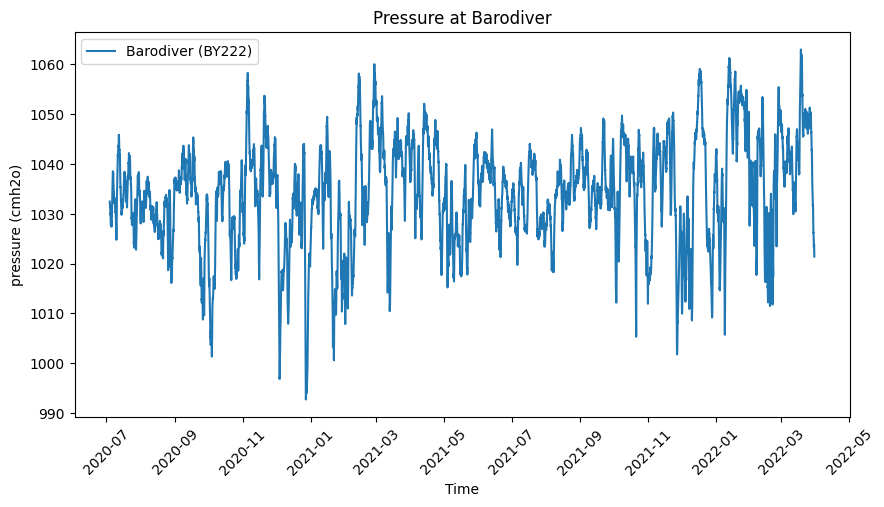

In [9]:
# identify the barometric timeseries in your dataset
baro = ds.filter(stations='Barodiver', variables='pressure')
baro.plot()  # Timeseries have a .plot()

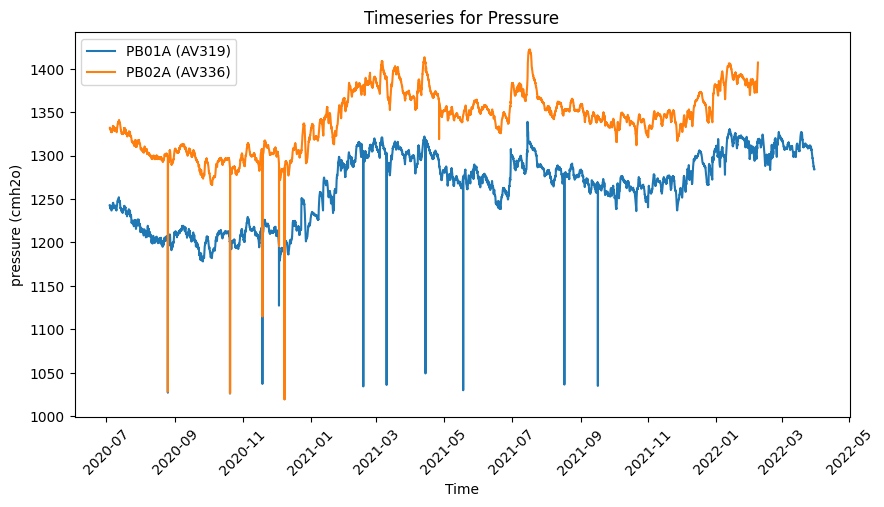

In [10]:
# Adding extra information to the submerged sensor timeseries. This could also
# be imported from a json file or a csv and converted into a dictionary.
alts = {
    "PB01A": 31.48,
    "PB02A": 31.68
    }

groundwater_ds = ds.filter(stations=alts.keys(), variables="pressure")

# we will loop over the dataset and attach the sensor altitude to the timeseries
# based on the location name.
for ts in groundwater_ds:
    ts.sensor_alt = alts.get(ts.location)

groundwater_ds.plot()

The sudden dips visible in the graph above are measurements taken by the diver when it was out of the water for some time or when pumping was done. The safest way to deal with this is to remove the measuremenst from the day of the fieldwork.

The compensate function accepts either a `Dataset` or `Timeseries` objects. It also accepts a dictionary containing lists of fieldwork dates per station, which are then used by the function to mask the erroneous measuremsnt. Another option is to drop measuremsnt that have a low water column, but it puts you at risk of removing valid measurements as well.

In [12]:
fieldwork_days = {"PB01A": ['2020-08-25', '2020-10-20', '2020-11-18', '2020-12-03', '2020-12-08',
                  '2021-02-17', '2021-03-10', '2021-04-14', '2021-05-18', '2021-05-27',
                  '2021-08-17', '2021-09-16'],
                  "PB02A": ['2020-08-25', '2020-10-20', '2020-11-18', '2020-12-03', '2020-12-08',
                  '2021-02-17', '2021-03-10', '2021-04-14', '2021-05-18', '2021-05-27',
                  '2021-08-17', '2021-09-16', '2021-04-26']}

compensated_ds = gs.compensate(groundwater_ds, baro, fieldwork_dates=fieldwork_days, interpolate_method='linear')

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Head at PB02A'}, xlabel='Time', ylabel='head (m asl)'>)

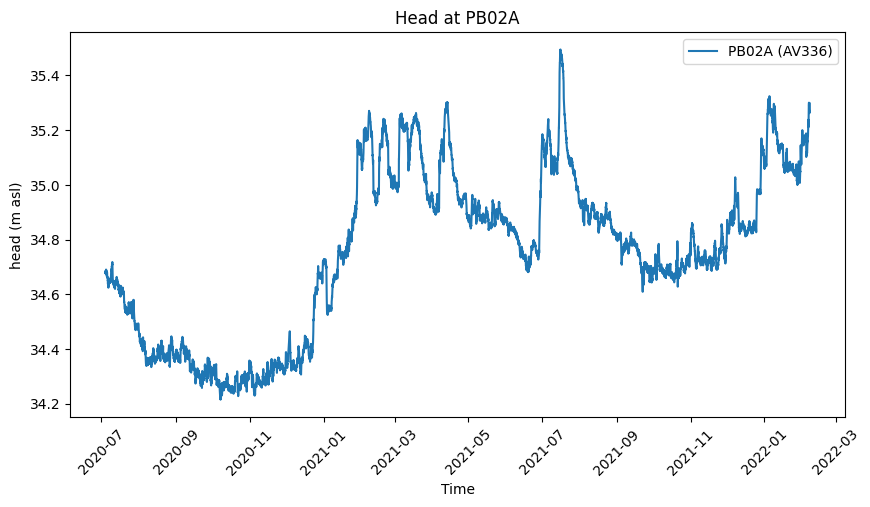

In [13]:
compensated_ds[1].plot()

As you can see, the measurements are now expressed as head and units changed to m asl. The compensation worked, but there are still some visible outliers. We will tackle this problem in the next tutorial [Example 2: Transformation and outlier detection](../002-transformation-and-outliers).